# Imports and installs

In this notebook, we render figures from data assumed to already be generated and saved (see companion notebook).

This notebook is designed to be run in Google Colab, in which the path ```/content``` exists. To use this notebook outside of Colab, only self-evident changes to the Imports and Installs section should be necessary. This first cell isn't required if ```neural_tangents``` and ```eigenlearning``` are already installed.

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

This cell installs $\LaTeX$ for use in plot rendering. If you already have it installed, you can likely remove this cell.

In [ ]:
%%capture
!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-extra

In [ ]:
import json
import math
import random

import jax
import jax.numpy as np

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

main_dir = '/content/drive/Shareddrives/Eigenlearning/'

In [ ]:
def lighten(color, factor=2):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - (1 - c[1])/factor, c[2])

def opacify(color, alpha=.5):
  return tuple(list(color) + [alpha])

In [ ]:
domains = ['circle', 'hypercube', 'hypersphere']

# Render figures

## Illustrative toy problem plots

##### Read in results

In [ ]:
resultsA = {'circle':{'int':{}, 'exp':{},'th':{}}}

with open(main_dir + 'A/circle/results_int.json', 'r') as file:
  resultsA['circle']['int'] = json.load(file)
with open(main_dir + 'A/circle/results_exp.json', 'r') as file:
  resultsA['circle']['exp'] = json.load(file)
with open(main_dir + 'A/circle/results_th.json', 'r') as file:
  resultsA['circle']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for rtype in ['exp', 'th']:
  keys = list(resultsA['circle'][rtype].keys())
  for key in keys:
    if isinstance(key, str):
      k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
      resultsA['circle'][rtype][(k, n)] = resultsA['circle'][rtype][key]
      del resultsA['circle'][rtype][key]
for rtype in ['datasets', 'y_hats']:
  keys = list(resultsA['circle']['int'][rtype].keys())
  for key in keys:
    if isinstance(key, str):
      k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
      resultsA['circle']['int'][rtype][(k, n)] = resultsA['circle']['int'][rtype][key]
      del resultsA['circle']['int'][rtype][key]

##### Extract some metadata

In [ ]:
metadataA = {'circle':{'int':{},'exp':{},'th':{}}}

for rtype in ['exp', 'th']:
  metadataA['circle'][rtype]['ks'] = sorted(list(set([key[0] for key in resultsA['circle'][rtype]])))
  metadataA['circle'][rtype]['ns'] = sorted(list(set([key[1] for key in resultsA['circle'][rtype]])))

metadataA['circle']['int']['ks'] = sorted(list(set([key[0] for key in resultsA['circle']['int']['datasets']])))
metadataA['circle']['int']['ns'] = sorted(list(set([key[1] for key in resultsA['circle']['int']['datasets']])))

ks = metadataA['circle']['int']['ks']
ns_int = metadataA['circle']['int']['ns']
ns_exp = [n for n in metadataA['circle']['exp']['ns'] if n >= 1]
ns_th = [n for n in metadataA['circle']['th']['ns'] if n >= 1]

M = 256

Make plots

In [ ]:
def get_plotA_axs():
  # plt.subplots_adjust(hspace=10, wspace=10)

  fig = plt.figure(figsize=(16,14))
  outer_grid = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1,1])
  
  gridL = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec = outer_grid[0], wspace=.1, hspace=.13)
  gridR = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec = outer_grid[1], wspace=.25, hspace=.1)

  plt.subplots_adjust(hspace=.4, wspace=0)

  # gridR.update(top=.5)

  axsL = [plt.subplot(cell) for cell in gridL]
  axsL = [axsL[3*i:3*(i+1)] for i in range(round(len(axsL)/(3)))]

  axsR = [plt.subplot(cell) for cell in gridR]
  axsR = [axsR[3*i:3*(i+1)] for i in range(round(len(axsR)/2))]

  axs_combined = [axsL[i] + axsR[i] for i in range(len(axsL))]

  return fig, axs_combined

In [ ]:
colors = {
    ks[0]:[(0,0,1),(0,0,.5),(0,.7,.7),(0,.1,.7),(.4,.5,1)],
    ks[1]:[(1,0,0),(.5,0,0),(.7,.5,0),(.7,.1,.0),(1,.5,.4)]
  }

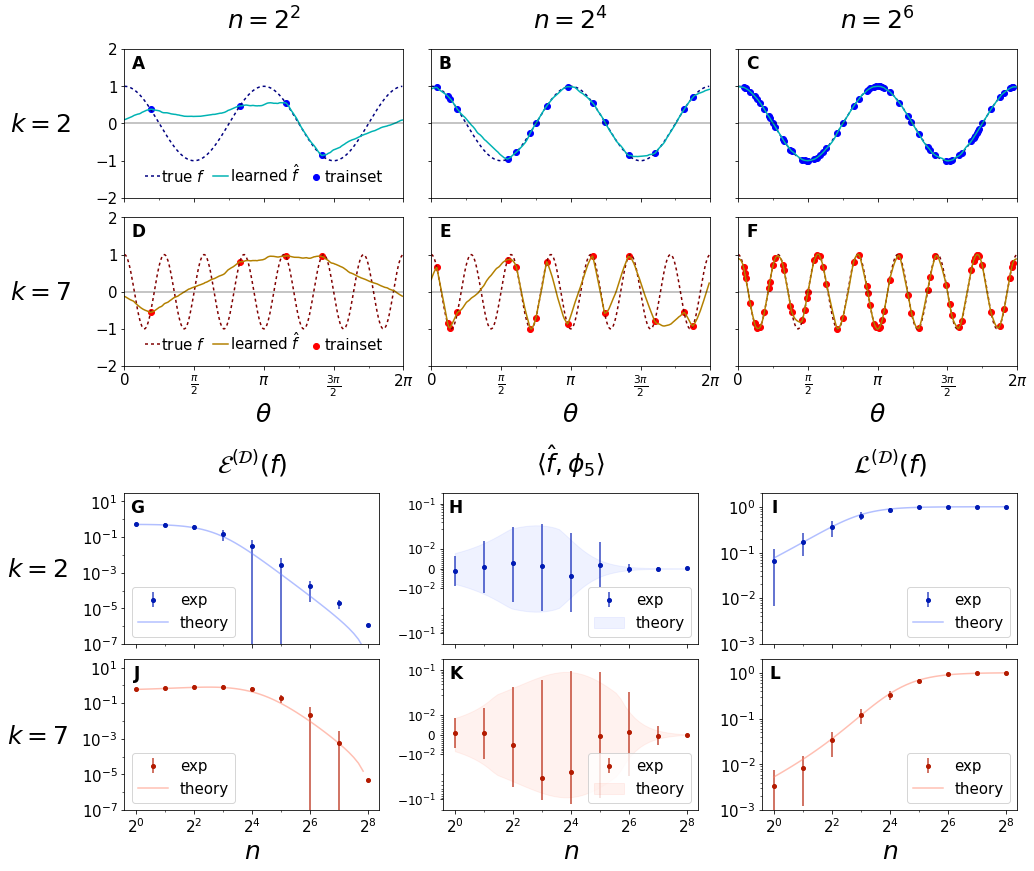

In [ ]:
fig, axs = get_plotA_axs()

# INTERPOLATION PLOTS
for i, k in enumerate(ks):
  for j, n in enumerate(ns_int):
    (train_thetas, train_X, train_y), (test_thetas, test_X, test_y) = resultsA['circle']['int']['datasets'][(k, n)]
    test_y_hat = resultsA['circle']['int']['y_hats'][(k, n)]

    (train_thetas, train_X, train_y), (test_thetas, test_X, test_y) = resultsA['circle']['int']['datasets'][(k, n)]
    test_y_hat = resultsA['circle']['int']['y_hats'][(k, n)]

    ax = axs[i][j]
    ax.plot(test_thetas, test_y, dashes=(2,2), label='true $f$', color=colors[k][1])
    ax.plot(test_thetas, test_y_hat, label='learned $\hat{f}$', color=colors[k][2])
    ax.scatter(train_thetas, train_y, label='trainset', color=colors[k][0])

    ax.plot([0,2*np.pi], [0,0], color=(0,0,0,.3))
    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([-2,2])

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks([np.pi*i/2 for i in range(5)], minor=False)
    ax.set_xticks([np.pi*(i/2+.25) for i in range(4)], minor=True)
    if i < (len(ks) - 1):
      ax.set_xticklabels([])
    else:
      ax.set_xticklabels(['0','$\\frac{\\pi}{2}$','$\\pi$','$\\frac{3\\pi}{2}$','$2\\pi$'])
      ax.set_xlabel('$\\theta$', fontsize=25)
      
    ax.set_yticks([-1, 1], minor=True)
    if j > 0:
      ax.set_yticklabels([])
    else:
      ax.set_ylabel(f'$k = {ks[i]}$', fontsize=25, rotation=0)
      ax.yaxis.set_label_coords(-.3,.41)
    
    if i == 0:
      if math.log2(n) == round(math.log2(n)):
        ax.set_title('$n = 2^{'+str(round(math.log2(n)))+'}$', fontsize=25, pad=20)
      else:
        ax.set_title(f'$n = {n}$', fontsize=25, pad=20)

    if j == 0:
      ax.legend(frameon=False, fontsize=15, ncol=3, handlelength=1, handletextpad=.1, columnspacing=.5, loc='lower center')

# MSE PLOTS
for i, k in enumerate(ks):
  ax = axs[i][len(ns_int)]

  # plot experimental MSE
  mse_data = list(zip(*[resultsA['circle']['exp'][(k,n)]['net']['mse'] for n in ns_exp]))
  ax.errorbar(ns_exp, mse_data[0], yerr=mse_data[1], fmt='o', label='exp', markersize=4, elinewidth=2, color=colors[k][3], ecolor=opacify(colors[k][3], .6))

  # plot theoretical MSE, dropping n=M since it gives ~zero error
  mse_preds = np.array([resultsA['circle']['th'][(k,n)]['mse'] for n in ns_th[:-1]])
  ax.plot(ns_th[:-1], mse_preds, label='theory', color=opacify(colors[k][4],.5))

  ax.set_yscale('log')
  ax.set_xscale('log')

  ax.set_xticks([2**i for i in range(0, round(math.log2(M)+1), 2)], minor=False)
  ax.set_xticks([2**i for i in range(1, round(math.log2(M)-1), 2)], minor=True)
  if i < (len(ks) - 1):
    ax.set_xticklabels([], minor=False)
    ax.set_xticklabels([], minor=True)
  else:
    ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(M)+1), 2)], minor=False)
    ax.set_xticklabels([], minor=True)
    ax.set_xlabel('$n$', fontsize=25)
  ax.set_yticks([10**i for i in range(-10, 10, 1)], minor=True)
  ax.set_yticklabels([], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=15)

  if i == 0:
    ax.set_title(r'$\mathcal{E}^{(\mathcal{D})}(f)$', fontsize=25, pad=20)
  
  ax.set_ylim((10**-7,30))

  handles, labels = ax.get_legend_handles_labels()
  ax.legend(reversed(handles), reversed(labels), frameon=True, fontsize=15, loc='lower left')

  ax.set_ylabel(f'$k = {k}$', fontsize=25, rotation=0)
  ax.yaxis.set_label_coords(-.34,.41)

# g_coeff PLOTS
for i, k in enumerate(ks):
  ax = axs[i][len(ns_int)+1]

  # plot experimental g coeffs
  g_coeff_data = list(zip(*[resultsA['circle']['exp'][(k,n)]['net']['g_coeffs'][0] for n in ns_exp]))
  ax.errorbar(ns_exp, g_coeff_data[0], yerr=g_coeff_data[1], fmt='o', label='exp', markersize=4, elinewidth=2, color=colors[k][3], ecolor=opacify(colors[k][3], .6))

  g_coeff_preds = 2**.5 * np.array([resultsA['circle']['th'][(k,n)]['g_coeffs'][0][1] for n in ns_th])
  ax.fill_between(ns_th, -g_coeff_preds, g_coeff_preds, label='theory', color=opacify(colors[k][4], .1))

  ax.set_xscale('log')
  ax.set_yscale('symlog', linthreshy=2*10**-2)

  ax.set_yticks([-.1, -.01, 0, .01, .1], minor=False)
  ax.set_yticks([10**-1 * i for i in range(-10, 11)] + [10**-2 * i for i in range(-10, 11)] + [10**-3 * i for i in range(-10, 11)], minor=True)
  ax.set_yticklabels(['$-10^{-1}$', '$-10^{-2}$', '$0$', '$10^{-2}$', '$10^{-1}$'], minor=False)

  ax.set_xticks([2**i for i in range(0, round(math.log2(M)+1), 2)], minor=False)
  ax.set_xticks([2**i for i in range(1, round(math.log2(M)-1), 2)], minor=True)

  if i < (len(ks) - 1):
    ax.set_xticklabels([], minor=False)
    ax.set_xticklabels([], minor=True)
  else:
    ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(M)+1), 2)], minor=False)
    ax.set_xticklabels([], minor=True)
    ax.set_xlabel('$n$', fontsize=25)
  ax.tick_params(axis='x', which='major', labelsize=15)
  ax.tick_params(axis='y', which='major', labelsize=12)

  ax.set_ylim((-.2,.2))

  if i == 0:
    ax.set_title(r'$ \langle \hat{f}, \phi_{5} \rangle $', fontsize=25, pad=20)

  handles, labels = ax.get_legend_handles_labels()
  ax.legend(reversed(handles), reversed(labels), frameon=True, fontsize=15, loc='lower right')

# LEARNABILITY PLOTS
for i, k in enumerate(ks):
  ax = axs[i][len(ns_int)+2]

  # plot experimental MSE
  lrn_data = list(zip(*[resultsA['circle']['exp'][(k,n)]['net']['lrn'] for n in ns_exp]))
  ax.errorbar(ns_exp, lrn_data[0], yerr=lrn_data[1], fmt='o', label='exp', markersize=4, elinewidth=2, color=colors[k][3], ecolor=opacify(colors[k][3], .6))

  # calculate and plot theoretical L
  lrn_preds = [resultsA['circle']['th'][(k,n)]['lrn'] for n in ns_th]
  ax.plot(ns_th, lrn_preds, label='theory', color=opacify(colors[k][4],.5))

  ax.set_yscale('log')
  ax.set_xscale('log')

  ax.set_xticks([2**i for i in range(0, round(math.log2(M)+1), 2)], minor=False)
  ax.set_xticks([2**i for i in range(1, round(math.log2(M)-1), 2)], minor=True)
  if i < (len(ks) - 1):
    ax.set_xticklabels([], minor=False)
    ax.set_xticklabels([], minor=True)
  else:
    ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(M)+1), 2)], minor=False)
    ax.set_xticklabels([], minor=True)
    ax.set_xlabel('$n$', fontsize=25)
  ax.tick_params(axis='both', which='major', labelsize=15)

  if i == 0:
    ax.set_title(r'$\mathcal{L}^{(\mathcal{D})}(f)$', fontsize=25, pad=20)
  
  ax.set_ylim((10**-3,2))

  handles, labels = ax.get_legend_handles_labels()
  ax.legend(reversed(handles), reversed(labels), frameon=True, fontsize=15, loc='lower right')

for i in range(len(axs)):
  for j in range(len(axs[0])):
    pos = (.05, .87)
    axs[i][j].text(*pos, ['ABCGHI','DEFJKL'][i][j], transform=axs[i][j].transAxes, size=17, weight='bold', ha='center')

plt.savefig('toy_problem.pdf')

## Learnability curves

##### Read in results

In [ ]:
resultsB = {domain:{'exp':{},'th':{}} for domain in domains}

with open(main_dir + 'B/circle/results_exp.json', 'r') as file:
  resultsB['circle']['exp'] = json.load(file)
with open(main_dir + 'B/circle/results_th.json', 'r') as file:
  resultsB['circle']['th'] = json.load(file)

with open(main_dir + 'B/hypercube/results_exp.json', 'r') as file:
  resultsB['hypercube']['exp'] = json.load(file)
with open(main_dir + 'B/hypercube/results_th.json', 'r') as file:
  resultsB['hypercube']['th'] = json.load(file)

with open(main_dir + 'B/hypersphere/results_exp.json', 'r') as file:
  resultsB['hypersphere']['exp'] = json.load(file)
with open(main_dir + 'B/hypersphere/results_th.json', 'r') as file:
  resultsB['hypersphere']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for domain in domains:
  for rtype in ['exp', 'th']:
    keys = list(resultsB[domain][rtype].keys())
    for key in keys:
      if isinstance(key, str):
        k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
        resultsB[domain][rtype][(k, n)] = resultsB[domain][rtype][key]
        del resultsB[domain][rtype][key]

##### Extract some metadata

In [ ]:
metadataB = {domain:{'exp':{},'th':{}} for domain in domains}

for domain in domains:
  for rtype in ['exp', 'th']:
    metadataB[domain][rtype]['ks'] = sorted(list(set([key[0] for key in resultsB[domain][rtype]])))
    metadataB[domain][rtype]['ns'] = sorted(list(set([key[1] for key in resultsB[domain][rtype]])))

##### Make plots

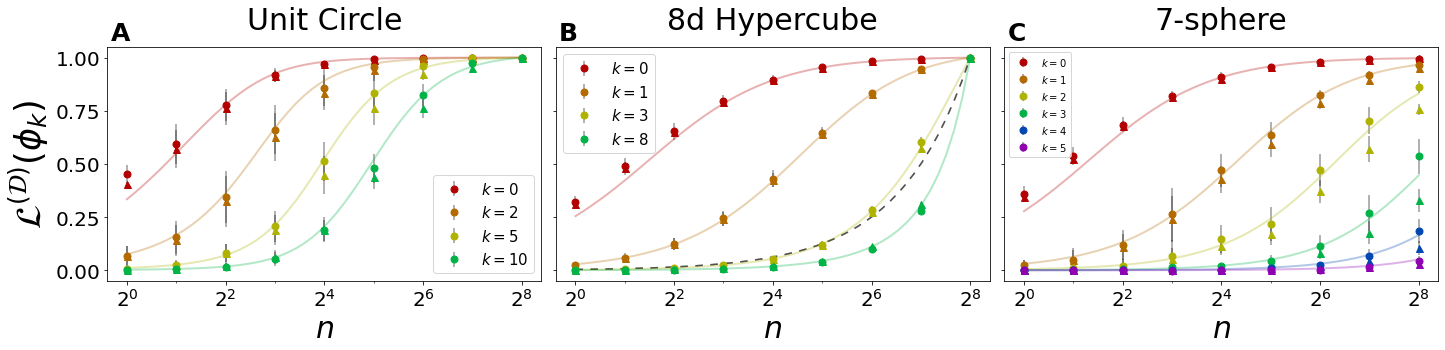

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, ax, domain in zip(range(3), axs, domains):
  ax.set_xscale('symlog', linthreshx=1)
  # ax.set_yscale('log')

  ks = metadataB[domain]['th']['ks']
  colors = {ks[i] : hsv_to_rgb(([0,.1,.17,.4,.6,.8][i],1,.7)) for i in range(len(ks))}

  ns_th = [n for n in metadataB[domain]['th']['ns'] if n >= 1]
  ns_exp = np.array([n for n in metadataB[domain]['exp']['ns'] if n >= 1])

  for k in ks:
    lrns_th = [resultsB[domain]['th'][(k, n)]['lrn'] for n in ns_th]

    lrns_k_mean, lrns_k_std = np.array([resultsB[domain]['exp'][(k, n)]['kernel']['lrn'] for n in ns_exp]).T
    lrns_n_mean, lrns_n_std = np.array([resultsB[domain]['exp'][(k, n)]['net']['lrn'] for n in ns_exp]).T

    # opacify(colors[k], alpha=1)
    ax.errorbar(ns_exp, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'$k={k}$')
    ax.errorbar(ns_exp, lrns_k_mean, yerr=lrns_k_std, fmt='^', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
    ax.plot(ns_th, lrns_th, color=opacify(colors[k], alpha=.3), lw=2)

    if i in [1]:
      ax.plot(ns_th, np.array(ns_th)/max(ns_th), color=(0,0,0,.25), linestyle=(0,(5,5)))
  
  ax.legend(ncol=1, fontsize=[15,15,10][i])

  ax.set_xticks([2**i for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
  ax.set_xticks([2**i for i in range(1, round(math.log2(max(ns_exp))-1), 2)], minor=True)
  ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
  ax.set_xticklabels([], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=20)
  if i > 0:
    ax.set_yticklabels([])
  ax.set_ylim((-.05, 1.05))

  ax.set_xlabel('$n$', fontsize=30)
  if i == 0:
    ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=35)
  
  title = ['Unit Circle', '8d Hypercube', '7-sphere'][i]
  ax.set_title(title, fontsize=30, y=1.05)
  ax.text(.03, 1.03, 'ABC'[i], transform=ax.transAxes, size=25, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('lrn_curves.pdf')

## Universal sigmoidal learnability curves

##### Read in results

In [ ]:
resultsC = {domain:{'exp':{},'th':{}} for domain in domains}

with open(main_dir + 'C/circle/results_exp.json', 'r') as file:
  resultsC['circle']['exp'] = json.load(file)
with open(main_dir + 'C/circle/results_th.json', 'r') as file:
  resultsC['circle']['th'] = json.load(file)

with open(main_dir + 'C/hypercube/results_exp.json', 'r') as file:
  resultsC['hypercube']['exp'] = json.load(file)
with open(main_dir + 'C/hypercube/results_th.json', 'r') as file:
  resultsC['hypercube']['th'] = json.load(file)

with open(main_dir + 'C/hypersphere/results_exp.json', 'r') as file:
  resultsC['hypersphere']['exp'] = json.load(file)
with open(main_dir + 'C/hypersphere/results_th.json', 'r') as file:
  resultsC['hypersphere']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for domain in domains:
  for rtype in ['exp']:
    keys = list(resultsC[domain][rtype].keys())
    for key in keys:
      if isinstance(key, str):
        k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
        resultsC[domain][rtype][(k, n)] = resultsC[domain][rtype][key]
        del resultsC[domain][rtype][key]

##### Extract some metadata

In [ ]:
metadataC = {domain:{} for domain in domains}

for domain in domains:
    metadataC[domain]['ks'] = sorted(list(set([key[0] for key in resultsC[domain]['exp']])))
    metadataC[domain]['ns'] = sorted(list(set([key[1] for key in resultsC[domain]['exp']])))

In [ ]:
metadataC

{'circle': {'ks': [0, 1, 2, 3, 4, 5, 6, 7], 'ns': [8, 64]},
 'hypercube': {'ks': [0, 1, 2, 3, 4, 5, 6], 'ns': [8, 64]},
 'hypersphere': {'ks': [0, 1, 2, 3, 4, 5, 6, 7], 'ns': [8, 64]}}

##### Make plots

In [ ]:
def get_plotC_axs(nrows, ncolsL):
  plt.subplots_adjust(hspace=0, wspace=.03)

  fig = plt.figure(figsize=(20,8))
  outer_grid = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3, 1.5])
  
  gridL = gridspec.GridSpecFromSubplotSpec(nrows, ncolsL, subplot_spec = outer_grid[0], wspace=.05, hspace=.15)
  gridR = gridspec.GridSpecFromSubplotSpec(9, 1, subplot_spec = outer_grid[1], wspace=.25, hspace=.05)

  axsL = [plt.subplot(cell) for cell in gridL]
  axsL = [axsL[ncolsL*i:ncolsL*(i+1)] for i in range(round(len(axsL)/2))]
  axR = plt.subplot(gridR[2:8])

  # axs_combined = axsL + [axR]

  return fig, axsL, axR

<Figure size 432x288 with 0 Axes>

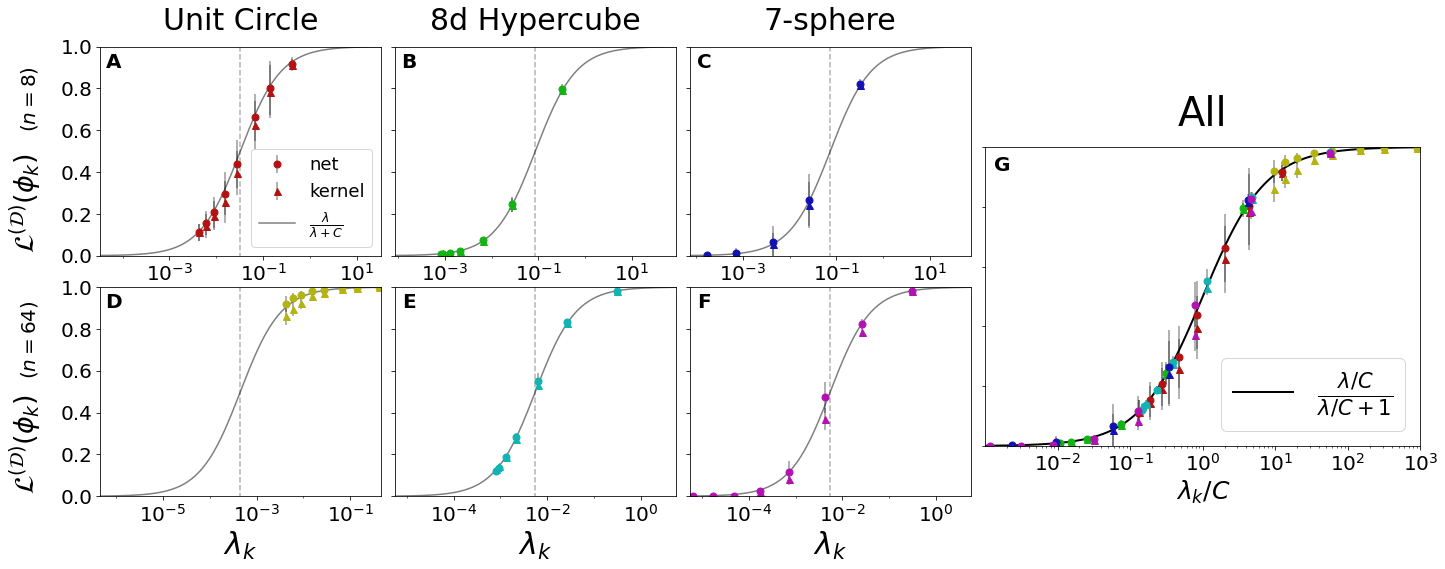

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig, axs, axR = get_plotC_axs(2, 3)


colors = [hsv_to_rgb((i/6,.9,.7)) for i in range(6)]

for i, domain in enumerate(domains):

  ks = metadataC[domain]['ks']
  ns = metadataC[domain]['ns']

  for j, n in enumerate(ns):

    ax = axs[j][i]
    ax.set_xscale('log')
    # ax.set_yscale('log')

    C = resultsC[domain]['th']['Cs'][f'{n}']

    lambdas_exp = np.array([resultsC[domain]['th']['lambdas'][k] for k in ks])
    # lrns_k_exp = lambdas_exp / (lambdas_exp + C)

    lrns_k_mean, lrns_k_std = np.array([resultsC[domain]['exp'][(k, n)]['kernel']['lrn'] for k in ks]).T
    lrns_n_mean, lrns_n_std = np.array([resultsC[domain]['exp'][(k, n)]['net']['lrn'] for k in ks]).T

    # l_min, l_max = min(C*.001, min(lambdas_exp)*.7), max(C*1000, max(lambdas_exp)*1.4)
    l_min, l_max = C*.001, C*1000
    lambdas_th = np.logspace(math.log10(l_min), math.log10(l_max), num=300)
    lrns_th = lambdas_th / (lambdas_th + C)

    color = colors[i*len(ns)+j]
    ax.errorbar(lambdas_exp, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label='net')
    ax.errorbar(lambdas_exp, lrns_k_mean, yerr=lrns_k_std, fmt='^', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label='kernel')
    ax.plot(lambdas_th, lrns_th, color=(0,0,0,.5), label=r'$\frac{\lambda}{\lambda + C}$')

    axR.errorbar(lambdas_exp/C, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
    axR.errorbar(lambdas_exp/C, lrns_k_mean, yerr=lrns_k_std, fmt='^', color=color, ecolor=(0,0,0,.3), markersize=7, elinewidth=2)

    ax.plot([C, C], [-1, 2], color=(0,0,0,.3), linestyle='--')
    
    ax.set_xticks([10**i for i in range(-10,10)], minor=True)
    ax.set_xticklabels([], minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20, length=4)
    ax.tick_params(axis='both', which='minor', length=2)

    if i > 0:
      ax.set_yticklabels([])
    if i == 0:
      # plt.rc('text', usetex=True)
      # plt.ylabel(r'\small{Text 1} \Huge{Text2}')
      ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=27)#, x=-.35, y=.3)
      ax.yaxis.set_label_coords(-.20,.25)
      ax.text(-.25, .75, f'($n={n}$)', fontsize=20, ha='center', va='center', transform=ax.transAxes, rotation=90)

    if j == len(ns) - 1:
      ax.set_xlabel('$\lambda_k$', fontsize=30)
    else:
      title = ['Unit Circle', '8d Hypercube', '7-sphere'][i]
      ax.set_title(title, fontsize=30, y=1.05)
    
    if i == 0 and j == 0:
      handles, labels = ax.get_legend_handles_labels()
      labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
      ax.legend(handles, labels, fontsize=18, loc='lower right')
    
    ax.text(.05, .90, ['ABC','DEF'][j][i], transform=ax.transAxes, size=20, weight='bold', ha='center')

    ax.set_xlim((l_min, l_max))
    ax.set_ylim((0, 1))

xs_th = np.logspace(-3, 3, num=300)
lrns_th = xs_th / (xs_th + 1)
axR.plot(xs_th, lrns_th, color=(0,0,0), lw=2, label=r'$\frac{\lambda/C}{\lambda/C+1}$')

axR.set_xscale('log')
axR.tick_params(axis='both', which='major', labelsize=20)
axR.set_xlabel('$\lambda_k / C$', fontsize=25)
axR.set_yticklabels([])
axR.set_title('All', fontsize=40, y=1.05)
axR.set_xlim((min(xs_th),max(xs_th)))
axR.set_ylim((0,1))
axR.legend(fontsize=30, loc='lower right')
axR.text(.04, .92, 'G', transform=axR.transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('universal_lrn_curves.pdf')

## Nonmonotonic MSE curves

##### Read in results

In [ ]:
resultsD = {domain:{'exp':{},'th':{}} for domain in domains}

with open(main_dir + 'D/circle/results_exp.json', 'r') as file:
  resultsD['circle']['exp'] = json.load(file)
with open(main_dir + 'D/circle/results_th.json', 'r') as file:
  resultsD['circle']['th'] = json.load(file)

with open(main_dir + 'D/hypercube/results_exp.json', 'r') as file:
  resultsD['hypercube']['exp'] = json.load(file)
with open(main_dir + 'D/hypercube/results_th.json', 'r') as file:
  resultsD['hypercube']['th'] = json.load(file)

with open(main_dir + 'D/hypersphere/results_exp.json', 'r') as file:
  resultsD['hypersphere']['exp'] = json.load(file)
with open(main_dir + 'D/hypersphere/results_th.json', 'r') as file:
  resultsD['hypersphere']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for domain in domains:
  for rtype in ['exp','th']:
    keys = list(resultsD[domain][rtype].keys())
    for key in keys:
      if isinstance(key, str) and key != 'dE_dn':
        k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
        resultsD[domain][rtype][(k, n)] = resultsD[domain][rtype][key]
        del resultsD[domain][rtype][key]

In [ ]:
for domain in domains:
  resultsD[domain]['dE_dn'] = resultsD[domain]['th']['dE_dn']
  del resultsD[domain]['th']['dE_dn']

##### Extract some metadata

In [ ]:
metadataD = {domain:{} for domain in domains}

for domain in domains:
    metadataD[domain]['ks'] = sorted(list(set([key[0] for key in resultsD[domain]['exp']])))
    metadataD[domain]['ns_exp'] = sorted(list(set([key[1] for key in resultsD[domain]['exp']])))
    metadataD[domain]['ns_th'] = sorted(list(set([key[1] for key in resultsD[domain]['th']])))

Make plots

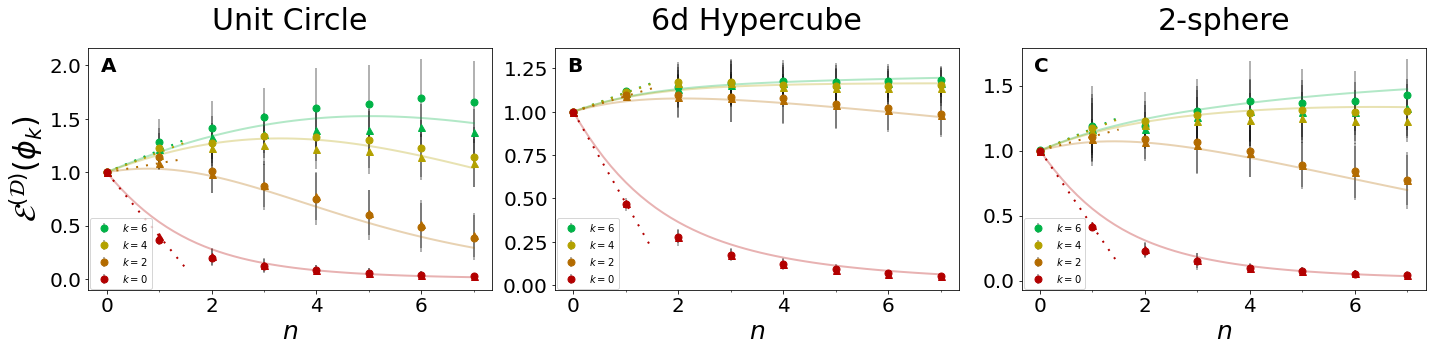

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, domain in enumerate(domains):
  ks = metadataD[domain]['ks']
  ax = axs[i]

  colors = {ks[i] : hsv_to_rgb(([0,.1,.15,.4,.5,.65,.75,.9][i],1,.7)) for i in range(len(ks))}

  for k in reversed(ks[:4]):
    ns_th = sorted(list(set([key[1] for key in resultsD[domain]['th']])))
    ns_exp = sorted(list(set([key[1] for key in resultsD[domain]['exp']])))

    mses_th = [resultsD[domain]['th'][(k, n)]['mse'] for n in ns_th]

    mses_k_mean, mses_k_std = np.array([resultsD[domain]['exp'][(k, n)]['kernel']['mse'] for n in ns_exp]).T
    mses_n_mean, mses_n_std = np.array([resultsD[domain]['exp'][(k, n)]['net']['mse'] for n in ns_exp]).T

    ax.errorbar(ns_exp, mses_n_mean, yerr=mses_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'$k={k}$')
    ax.errorbar(ns_exp, mses_k_mean, yerr=mses_k_std, fmt='^', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
    ax.plot(ns_th, mses_th, color=opacify(colors[k], alpha=.3), lw=2)

    dE_dn = resultsD[domain]['dE_dn'][k]
    dn = 1.5
    ax.plot([0,dn], [1,1+dE_dn*dn], color=lighten(colors[k],1), linestyle=(0,(1,4)), lw=2)

  ax.set_xticks([1, 3, 5, 7], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=20)
  ax.set_xlabel(r'$n$', fontsize=25)

  if i == 0:
    ax.set_ylabel(r'$\mathcal{E}^{(\mathcal{D})} (\phi_k)$', fontsize=30)

  ax.set_title(['Unit Circle', '6d Hypercube', '2-sphere'][i], fontsize=30, y=1.05)
  ax.text(.05, .90, 'ABC'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')
  handles, labels = ax.get_legend_handles_labels()
  labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
  # ax.legend(handles, labels, fontsize=10, loc=[(.1,.3),(.6,.3),(.25,.25)][i], ncol=2)
  ax.legend(handles, labels, fontsize=10, loc=(.005,.005))

fig.tight_layout()

plt.savefig('nonmonotonic_mse_curves.pdf')

## Testing the "no-free-lunch" theorem

##### Read in results

In [ ]:
resultsE = {'circle': {'exp' : {}}}

with open(main_dir + 'E/circle/results_exp.json', 'r') as file:
  resultsE['circle']['exp'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
keys = list(resultsE['circle']['exp'].keys())
for key in keys:
  if isinstance(key, str):
    a, n, k, m = [int(x) if x.isdigit() else x for x in key.split(',')]
    resultsE['circle']['exp'][(a, n, k, m)] = resultsE['circle']['exp'][key]
    del resultsE['circle']['exp'][key]

##### Extract some metadata

In [ ]:
metadataE = {'as':set(), 'ns':set(), 'modes':set()}

for a, n, k, m in resultsE['circle']['exp'].keys():
  metadataE['as'].add(a)
  metadataE['ns'].add(n)
  metadataE['modes'].add((k,m))

for key in metadataE:
  metadataE[key] = sorted(list(metadataE[key]))

Make plots

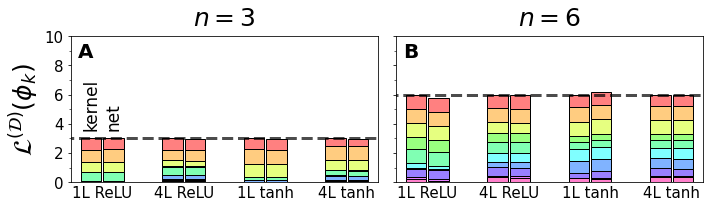

In [ ]:
ns = metadataE['ns']
archs = np.array(metadataE['as'])
modes = list(reversed(metadataE['modes']))

# colors_ker = [(.1,.1,.3 + .7*i/(len(modes)-1)) for i in range(len(modes))]
# colors_net = [(.3 + .7*i/(len(modes)-1),.1,.1) for i in range(len(modes))]

colors_ker = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]
colors_net = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]

fig, axs = plt.subplots(nrows=1, ncols=len(ns), figsize=(10,3))

A, B = 4, 1.1

for i, n in enumerate(ns):
  ax = axs[i]

  total_lrns_k = np.zeros_like(archs)
  total_lrns_n = np.zeros_like(archs)

  for j, (k, m) in enumerate(modes):
    mode_lrns_k = np.array([resultsE['circle']['exp'][a,n,k,m]['kernel']['lrn'][0] for a in archs])
    mode_lrns_n = np.array([resultsE['circle']['exp'][a,n,k,m]['net']['lrn'][0] for a in archs])

    ax.bar(A*archs, mode_lrns_k, width=1, bottom=total_lrns_k, color=colors_ker[j], edgecolor=(0,0,0), label='kernel' if j==len(modes)-1 else None)
    ax.bar(A*archs + B, mode_lrns_n, width=1, bottom=total_lrns_n, color=colors_net[j], edgecolor=(0,0,0), label='net' if j==len(modes)-1 else None)

    total_lrns_k += mode_lrns_k
    total_lrns_n += mode_lrns_n
  
  # print(total_lrns_k, total_lrns_n)

  ax.plot([-10,100], [n,n], color=(0,0,0,.7), linestyle='--', lw=3)
  ax.set_xlim(-1, A*(len(archs)-1)+B+1)
  ax.set_ylim((0, 10))

  xtick_xs = []
  xtick_labels = []
  for a in archs:
    net_name = ['1L ReLU', '4L ReLU', '1L tanh', '4L tanh'][a]
    xtick_xs += [a*A + B/2]
    xtick_labels += [net_name]
  ax.set_xticks(xtick_xs)
  ax.set_xticklabels(xtick_labels, fontsize=15)
  ax.set_yticks(range(0,11,2), minor=False)
  ax.set_yticks(range(1,10,2), minor=True)

  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', labelsize=15)

  if i > 0:
    ax.set_yticklabels([])
  if i == 0:
    ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=25)
    # ax.yaxis.set_label_coords(-.07,.5)

  ax.set_title(f'$n={n}$', fontsize=25, y=1.03)

  if i == 0:
    ax.text(0, 3.5, 'kernel', va='bottom', ha='center', rotation=90, fontsize=17)
    ax.text(B, 3.5, 'net', va='bottom', ha='center', rotation=90, fontsize=17)

  ax.text(.05, .85, 'AB'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('conservation_of_lrn.pdf')

## Repeating the hypercube experiment at various widths

##### Read in results

In [ ]:
resultsF = {domain:{'exp':{},'th':{}} for domain in domains}

ws = [500, 200, 100, 50, 20, 10]

for w in ws:
  with open(main_dir + f'F/hypercube/results_exp_w{w}.json', 'r') as file:
    resultsF['hypercube']['exp'][w] = json.load(file)
with open(main_dir + 'F/hypercube/results_th.json', 'r') as file:
  resultsF['hypercube']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
keys = list(resultsF['hypercube']['th'].keys())
for key in keys:
  if isinstance(key, str):
    k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
    resultsF['hypercube']['th'][(k, n)] = resultsF['hypercube']['th'][key]
    del resultsF['hypercube']['th'][key]

for w in ws:
  keys = list(resultsF['hypercube']['exp'][w].keys())
  for key in keys:
    if isinstance(key, str):
      ww, k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
      if ww == w:
        resultsF['hypercube']['exp'][w][(k, n)] = resultsF['hypercube']['exp'][w][key]
      del resultsF['hypercube']['exp'][w][key]

##### Extract some metadata

In [ ]:
metadataF = {domain:{'exp':{},'th':{}} for domain in ['hypercube']}

metadataF['hypercube']['th']['ks'] = sorted(list(set([key[0] for key in resultsF['hypercube']['th']])))
metadataF['hypercube']['th']['ns'] = sorted(list(set([key[1] for key in resultsF['hypercube']['th']])))

metadataF['hypercube']['exp']['ks'] = sorted(list(set([key[0] for key in resultsF['hypercube']['exp'][ws[0]]])))
metadataF['hypercube']['exp']['ns'] = sorted(list(set([key[1] for key in resultsF['hypercube']['exp'][ws[0]]])))

ks = metadataF['hypercube']['th']['ks']
ns_th = [n for n in metadataF['hypercube']['th']['ns'] if n >= 1]
ns_exp = np.array([n for n in metadataF['hypercube']['exp']['ns'] if n >= 1])
# ns_exp = ns_exp[:-1]

colors = {ks[i] : hsv_to_rgb(([0,.1,.17,.4,.6,.8][i],1,.7)) for i in range(len(ks))}

##### Make learnability plots

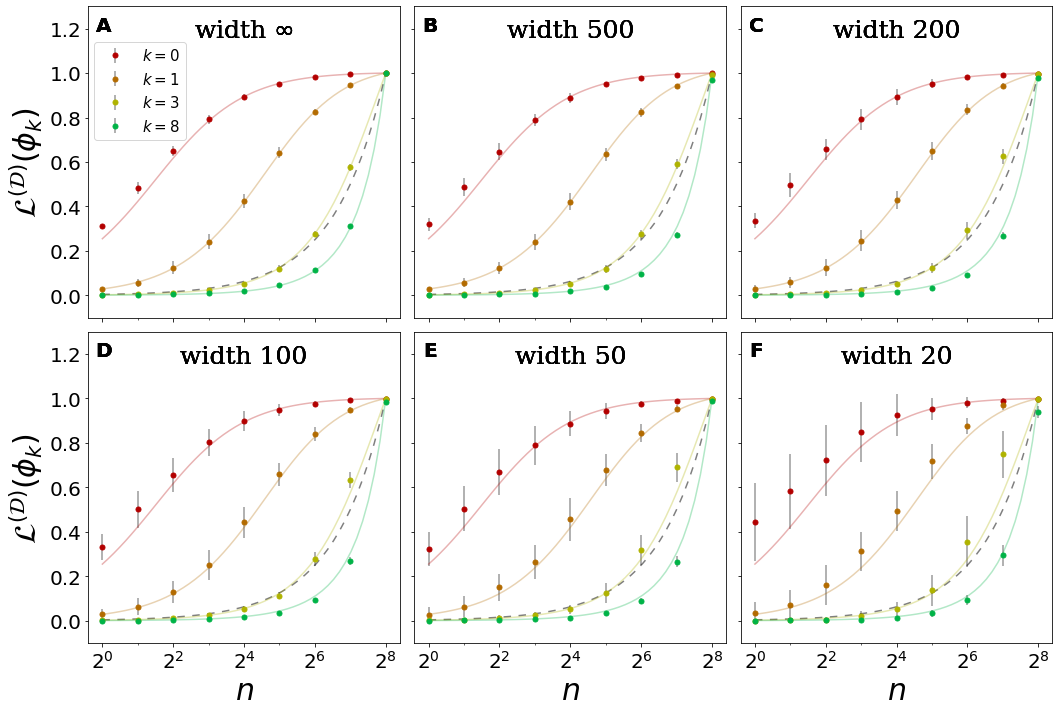

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

axs = axs[0].tolist() + axs[1].tolist()

domain = 'hypercube'

for i, w in enumerate(['$\infty$'] + ws[:-1]):
  ax = axs[i]
  ax.set_xscale('log')

  ax.plot(ns_th, np.array(ns_th)/max(ns_th), color=(0,0,0,.5), linestyle=(0,(5,5)), lw=1.5)

  for k in ks:
    lrns_th = [resultsF[domain]['th'][(k, n)]['lrn'] for n in ns_th]
    if w == '$\infty$':
      lrns_n_mean, lrns_n_std = np.array([resultsF[domain]['exp'][500][(k, n)]['kernel']['lrn'] for n in ns_exp]).T
    else:
      lrns_n_mean, lrns_n_std = np.array([resultsF[domain]['exp'][w][(k, n)]['net']['lrn'] for n in ns_exp]).T

    ax.errorbar(ns_exp, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=5, elinewidth=2, label=f'$k={k}$')
    ax.plot(ns_th, lrns_th, color=opacify(colors[k], alpha=.3))

    ax.set_xticks([2**i for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
    ax.set_xticks([2**i for i in range(1, round(math.log2(max(ns_exp))-1), 2)], minor=True)
    if i >= 3:
      ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
      ax.set_xticklabels([], minor=True)
      ax.set_xlabel('$n$', fontsize=30)
    else:
      ax.set_xticklabels([])
    if i not in [0,3]:
      ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.set_ylim((-.05, 1.05))
    
    if i in [0,3]:
      ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=30)
    
    # title = ['Unit Circle', '8D Hypercube', '7-sphere'][i]
    # ax.set_title(title, fontsize=20, y=1.05)
    ax.text(.05, .92, 'ABCDEF'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')
    ax.text(.5, .9, f'width {w}', transform=ax.transAxes, size=25, weight='light', ha='center', family='serif')

    if i == 0:
      ax.legend(ncol=1, fontsize=15, loc=(.02,.57))

  ax.set_ylim((-.1, 1.3))

fig.tight_layout()

plt.savefig('width_comparison_lrn.pdf')

Make MSE plots

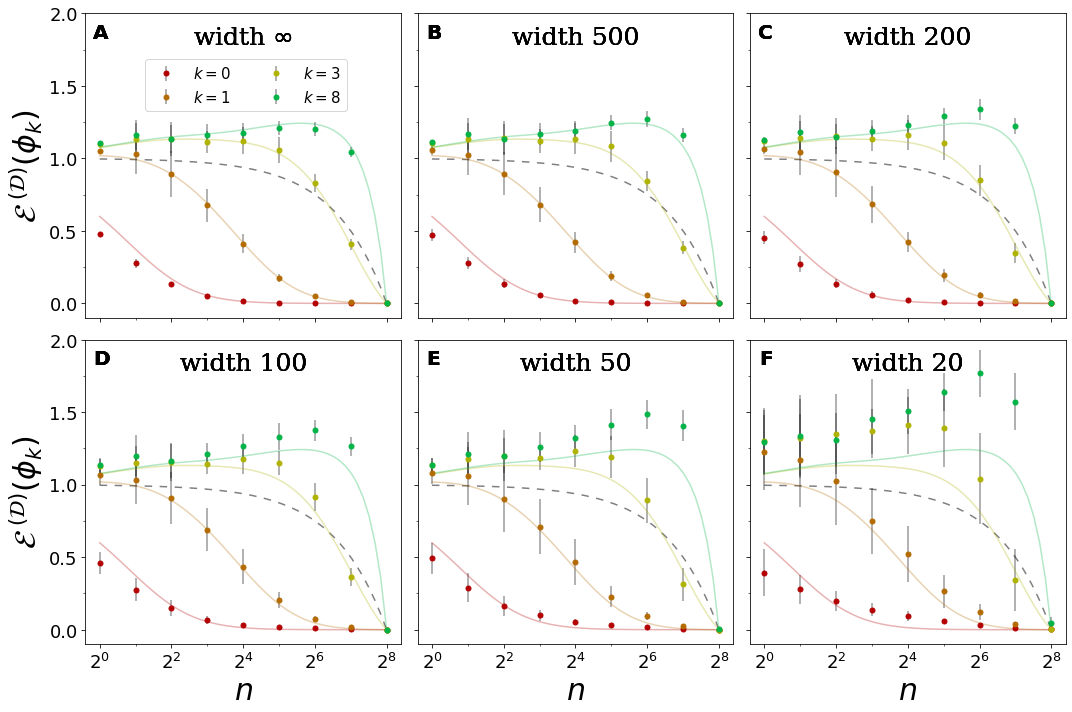

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

axs = axs[0].tolist() + axs[1].tolist()

domain = 'hypercube'

for i, w in enumerate(['$\infty$'] + ws[:-1]):
# for i, w in enumerate(ws):
  ax = axs[i]
  ax.set_xscale('log')

  ax.plot(ns_th, 1 - np.array(ns_th)/max(ns_th), color=(0,0,0,.5), linestyle=(0,(5,5)), lw=1.5)

  for k in ks:
    mses_th = [resultsF[domain]['th'][(k, n)]['mse'] for n in ns_th]
    if w == '$\infty$':
      mses_n_mean, mses_n_std = np.array([resultsF[domain]['exp'][500][(k, n)]['kernel']['mse'] for n in ns_exp]).T
    else:
      mses_n_mean, mses_n_std = np.array([resultsF[domain]['exp'][w][(k, n)]['net']['mse'] for n in ns_exp]).T

    ax.errorbar(ns_exp, mses_n_mean, yerr=mses_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=5, elinewidth=2, label=f'$k={k}$')
    ax.plot(ns_th, mses_th, color=opacify(colors[k], alpha=.3))

    ax.set_xticks([2**i for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
    ax.set_xticks([2**i for i in range(1, round(math.log2(max(ns_exp))-1), 2)], minor=True)
    if i >= 3:
      ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
      ax.set_xticklabels([], minor=True)
      ax.set_xlabel('$n$', fontsize=30)
    else:
      ax.set_xticklabels([])

    ax.set_yticks([.5*i for i in range(-10, 10)], minor=False)
    ax.set_yticks([.5*i + .25 for i in range(-10, 10)], minor=True)
    if i not in [0,3]:
      ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=18, length=4)
    
    ax.set_ylim((-.05, 1.05))

    if i in [0,3]:
      ax.set_ylabel(r'$\mathcal{E}^{\ (\mathcal{D})}(\phi_k)$', fontsize=30)
    
    # title = ['Unit Circle', '8D Hypercube', '7-sphere'][i]
    # ax.set_title(title, fontsize=20, y=1.05)
    ax.text(.05, .92, 'ABCDEF'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')
    ax.text(.5, .9, f'width {w}', transform=ax.transAxes, size=25, weight='light', ha='center', family='serif')

    if i == 0:
      ax.legend(ncol=2, fontsize=15, loc=(.19,.68))

  ax.set_ylim((-.1, 2))

fig.tight_layout()

plt.savefig('width_comparison_mse.pdf')

## Generating domain eigenvalues

In [ ]:
with open(main_dir + 'G/eigenvalues.json', 'r') as file:
  eigenvalues = json.load(file)

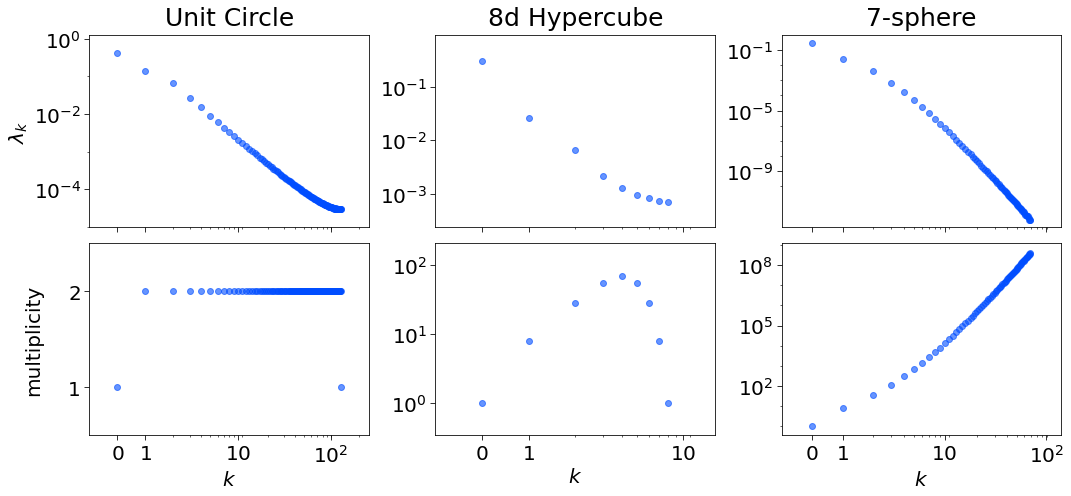

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7))

for i, domain in enumerate(domains):
  # PLOT LAMBDAS
  ax = axs[0][i]
  # ax.set_xscale('symlog', linthreshx=1)
  ax.set_xscale('log')
  ax.set_yscale('log')

  lambdas, mults = eigenvalues[domain]
  lambdas = np.array(lambdas)

  k_max = len(lambdas) if domain is not 'circle' else len(lambdas)//2 + 1
  ks = np.arange(0, k_max, dtype='uint32')
  ax.scatter(np.maximum(ks, .5), lambdas[ks], color=(0,.3,1,.6))

  ax.set_xticks([.5,1,10,100], minor=False)
  ax.set_xticklabels([], minor=False)
  ax.set_xticks([i for i in range(1,10,1)] + [i for i in range(1,100,10)] + [i for i in range(1,1000,100)], minor=True)
  ax.set_xticklabels([], minor=True)
  ax.set_yticks([10**i for i in range(-10,10)], minor=True)
  ax.set_yticklabels([], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=20, length=5)

  if i == 0:
    ax.set_ylabel('$\lambda_k$', fontsize=20)
  ax.set_title(['Unit Circle', '8d Hypercube', '7-sphere'][i], fontsize=25, pad=10)

  ax.set_xlim([.5/2, ks.max()*2])
  ax.set_ylim([lambdas.min()/3, lambdas.max()*3])

  # PLOT MULTIPLICITIES
  ax = axs[1][i]
  # ax.set_xscale('symlog', linthreshx=1)
  ax.set_xscale('log')
  ax.set_yscale('log')

  lambdas, mults = eigenvalues[domain]
  if domain == 'circle':
    mults = [1 if i in [0, len(mults)/2] else 2 for i in range(len(mults))]
  mults = np.array(mults)

  k_max = len(lambdas) if domain is not 'circle' else len(lambdas)//2 + 1
  ks = np.arange(0, k_max, dtype='uint32')
  ax.scatter(np.maximum(ks, .5), mults[ks], color=(0,.3,1,.6))

  ax.set_xticks([.5,1,10,100], minor=False)
  ax.set_xticklabels(['$0$', '$1$', '$10$', '$10^2$'], minor=False)
  ax.set_xticks([i for i in range(1,10,1)] + [i for i in range(1,100,10)] + [i for i in range(1,1000,100)], minor=True)
  ax.set_xticklabels([], minor=True)
  ax.set_yticks([10**i for i in range(-10,10)], minor=True)
  ax.set_yticklabels([], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=20, length=5)

  ax.set_xlabel('$k$', fontsize=20)
  if i == 0:
    ax.set_ylabel('multiplicity', fontsize=20, labelpad=25)

  ax.set_xlim([.5/2, ks.max()*2])
  ax.set_ylim([mults.min()/3, mults.max()*3])

  if domain == 'circle':
    ax.set_yscale('linear')
    ax.set_ylim((.5,2.5))
    ax.set_yticks([1,2])

fig.tight_layout()

plt.savefig('eigenvalues.pdf')

## Examining statistics of $C^{(\Phi, \phi)}$

In [ ]:
with open(main_dir + 'H/ratios.json', 'r') as file:
  resultsH = json.load(file)

ns = resultsH['ns']
ratios = resultsH['ratios']

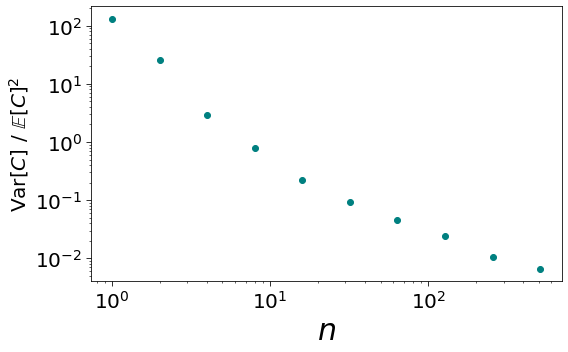

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(ns, ratios, color=(0,.5,.5))

ax.tick_params(axis='both', which='major', labelsize=20, length=5)

ax.set_xlabel('$n$', fontsize=30)
ax.set_ylabel('Var$[C] \ / \ \\mathbb{E}[C]^2$', fontsize=20)

fig.tight_layout()

plt.savefig('C_ratios.pdf')